In [1]:
%matplotlib inline
%load_ext lab_black
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from lcc import lcc

# import torch
# import torch.nn as nn
# import torch.optim as optim

from tqdm.notebook import tqdm

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# from torch.nn.functional import pad
# from torch.utils.data import DataLoader
# from torchvision import models
# from torchvision.datasets import ImageFolder

pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (8, 6)
fontsize = 18
figsize = (8, 6)


def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True


seed_everything()

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

In [3]:
# def primes_by_precision(n_bits=24, precision=16, n_features=500, max_abs=100):
#     low   = 2 ** (precision + 1) * max_abs + 1
#     high  = np.iinfo('int64').max - 1
#     n = 2 ** n_bits + 1
#     sieve = [True] * (n + 1)
#     good  = []
#     for p in tqdm(range(2, n + 1)):
#         if (sieve[p]):
#             if p >= low and n_features * (p - 1) ** 2 <= high:
#                 good.append(p)
#             for i in range(p, n + 1, p):
#                 sieve[i] = False
#     del sieve
#     return good

# precision = 12
# n_bits = 25
# primes = primes_by_precision(n_bits, precision, num_features, np.abs(X_train).max())

# plt.hist(primes, bins=100)
# prime_number = primes[-1]
# del primes
# prime_number.bit_length()

In [4]:
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing

In [54]:
min_max_scaler = preprocessing.MinMaxScaler((-128, 127))

num_samples, num_features = 10000, 50
low, high = -16, 15
true_weight = np.random.randn(num_features)
gm = GaussianMixture(
    n_components=2,
    weights_init=np.array([0.5, 0.5]),
    means_init=np.array(
        [1.5 * true_weight / num_features, -1.5 * true_weight / num_features]
    ),
    precisions_init=np.array([np.eye(num_features), np.eye(num_features)]),
)
gm.weights_, gm.means_, gm.covariances_ = (
    gm.weights_init,
    gm.means_init,
    gm.precisions_init,
)

X_train = gm.sample(num_samples)[0]
# X_train = min_max_scaler.fit_transform(X_train)

y_train = X_train.dot(true_weight)
print(X_train.shape, true_weight.shape, y_train.shape)

random_weight = np.random.randn(num_features)

(10000, 50) (50,) (10000,)


In [6]:
prime_number = 2**25 - 39
n_bits = prime_number.bit_length()

quantization_error = []
n_bits_range = np.arange(n_bits)
for l in tqdm(n_bits_range):
    quantization_error.append(
        np.linalg.norm(
            X_train
            - lcc.dequantize(lcc.quantize(X_train, l, prime_number), l, prime_number)
        )
    )

  0%|          | 0/25 [00:00<?, ?it/s]

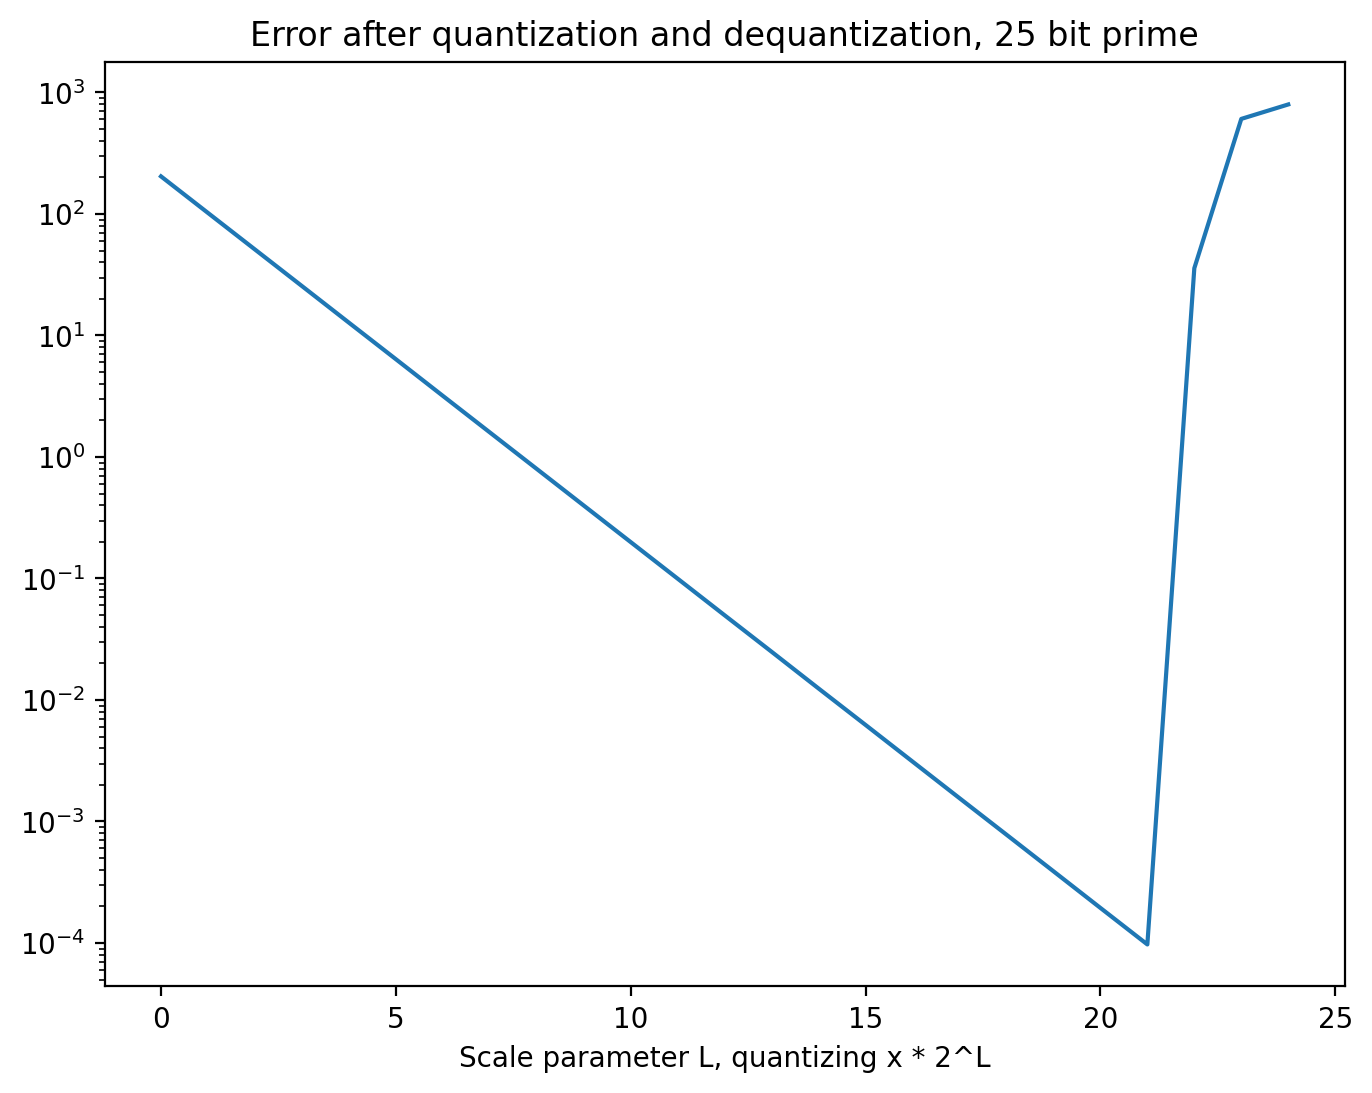

In [7]:
plt.title(f"Error after quantization and dequantization, {n_bits} bit prime")
plt.xlabel("Scale parameter L, quantizing x * 2^L")
plt.yscale("log")
plt.plot(n_bits_range, quantization_error)

In [8]:
precision = 8

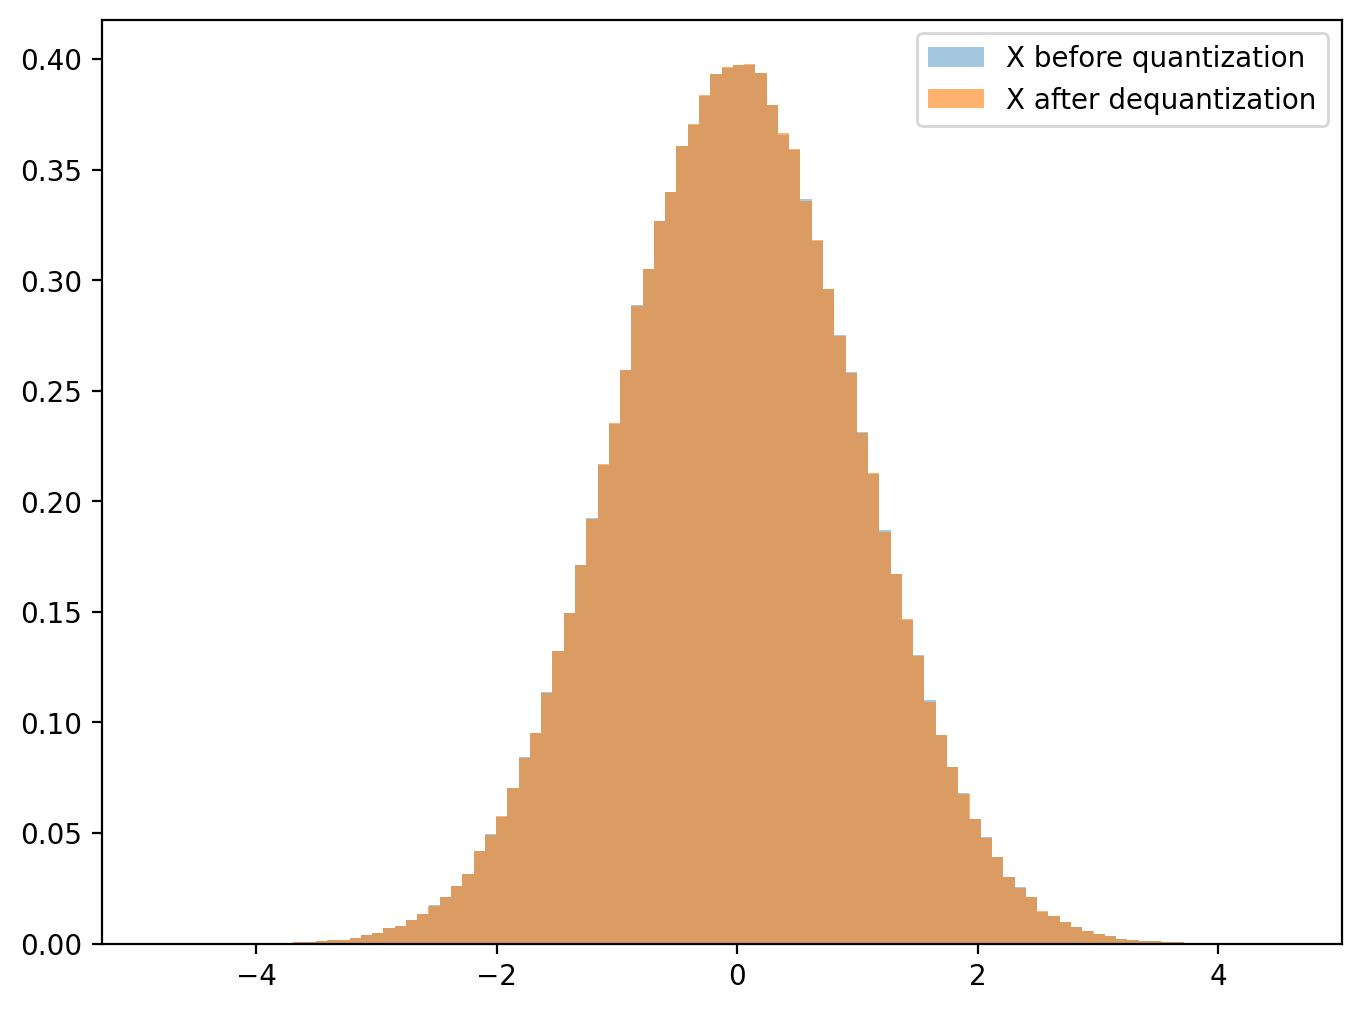

In [9]:
plt.hist(
    X_train.flatten(), bins=100, density=True, label="X before quantization", alpha=0.4
)
plt.hist(
    lcc.dequantize(
        lcc.quantize(X_train, precision, prime_number), precision, prime_number
    ).flatten(),
    alpha=0.6,
    bins=100,
    density=True,
    label="X after dequantization",
)
plt.legend()

Text(0.5, 1.0, 'X after quantization')

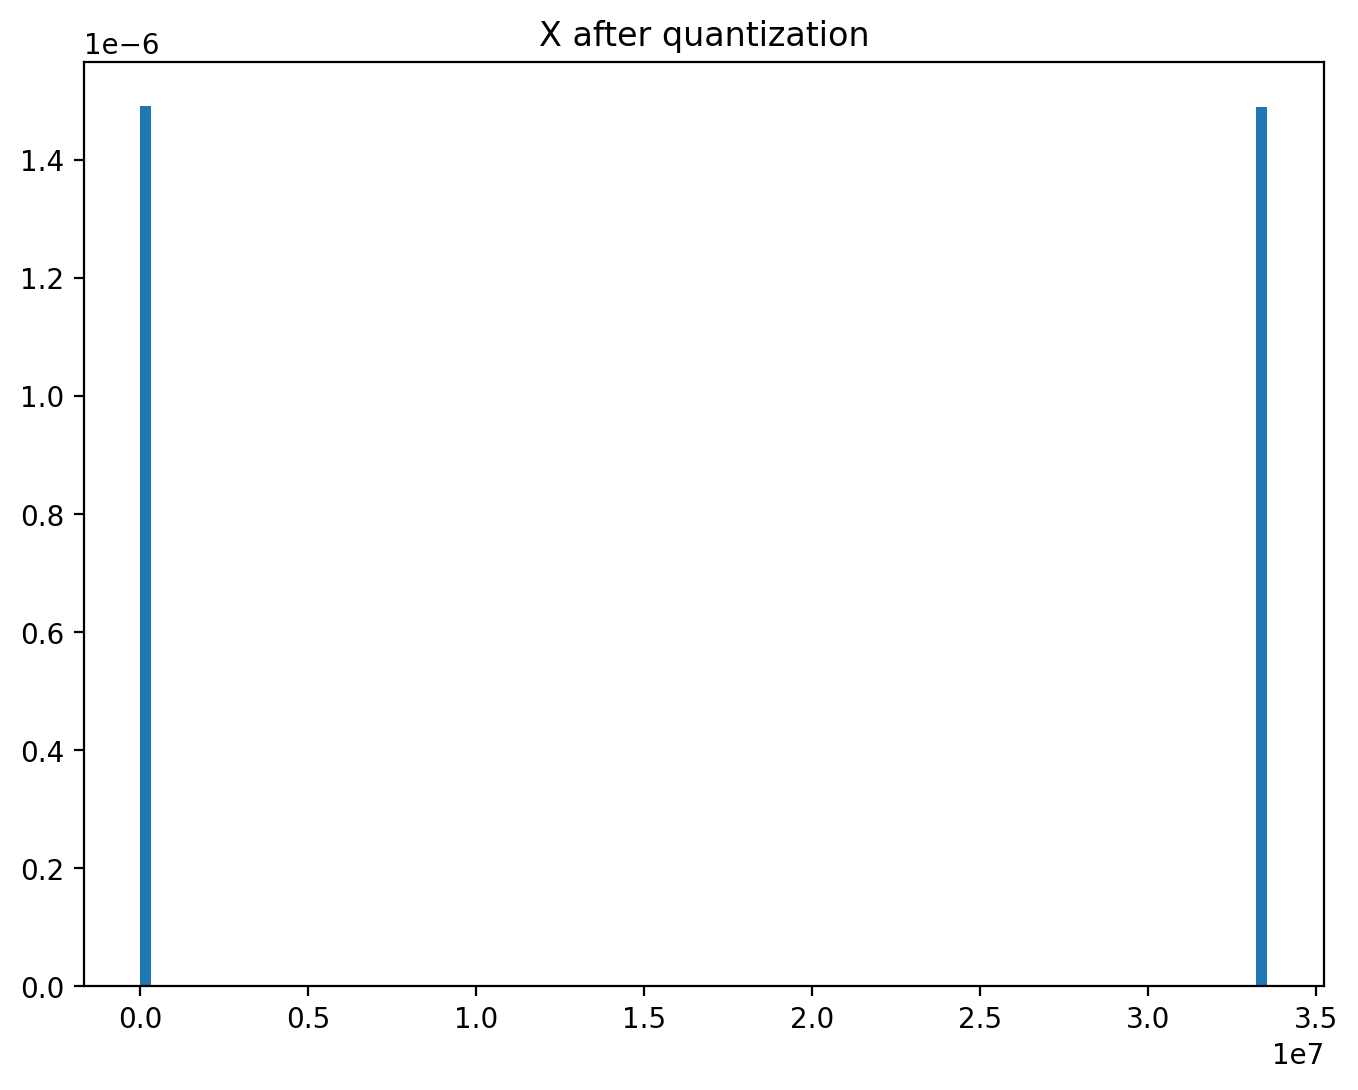

In [10]:
X_q = lcc.quantize(X_train, precision, prime_number).flatten()
plt.hist(X_q, bins=100, density=True)
plt.title("X after quantization")

In [11]:
class BaseSmoothOracle(object):
    """
    Base class for smooth function.
    """

    def func(self, x):
        """
        Computes the value of function at point x.
        """
        raise NotImplementedError("Func is not implemented.")

    def grad(self, x):
        """
        Computes the gradient vector at point x.
        """
        raise NotImplementedError("Grad is not implemented.")

In [39]:
class LCCLeastSquaresOracle(BaseSmoothOracle):
    """
    LCC oracle for least-squares regression.
        f(x) = 0.5 ||Xw - y||_2^2
    """

    def __init__(
        self,
        X,
        y,
        prime_number,
        num_workers=40,
        num_stragglers=5,
        security_guarantee=2,
        privacy_guarantee=2,
        precision=16,
        fit_intercept=False,
    ):
        self.X = np.hstack((np.ones((len(X), 1)), X)) if fit_intercept else X
        self.y = y
        self.XTy = self.X.T.dot(y)
        self.Xq = lcc.quantize(self.X, precision, prime_number)
        self.yq = lcc.quantize(self.y, precision, prime_number)

        self.num_workers = num_workers  # N
        self.num_stragglers = num_stragglers  # S
        self.security_guarantee = security_guarantee  # A
        self.privacy_guarantee = privacy_guarantee  # T
        self.prime_number = prime_number
        self.precision = precision
        self.fit_intercept = fit_intercept

        self._init_num_batches()  # K
        self._precomputation()

    def _init_num_batches(self):
        self.poly_degree = 2  # X.T.dot(X)
        self.num_batches = (
            (self.num_workers - 1 - 2 * self.security_guarantee - self.num_stragglers)
            // self.poly_degree
            + 1
            - self.privacy_guarantee
        )
        m, _ = self.X.shape
        while m % self.num_batches:
            self.num_batches -= 1
        self.n_bound = (
            self.num_batches + self.privacy_guarantee - 1
        ) * self.poly_degree + 1
        print(f"Initialized K={self.num_batches} batches")
        print(f"Number of succedeed to restore correctly: N>={self.n_bound}")

    def _precomputation(self):
        n_betas = self.num_batches + self.privacy_guarantee
        n_alphas = self.num_workers
        self.alphas = (np.arange(2 * n_alphas, step=2)).astype("int64")
        self.betas = (np.arange(1, 2 * n_betas, step=2)).astype("int64")
        self.U = lcc.gen_Lagrange_coeffs(self.alphas, self.betas, self.prime_number)
        Xq_split = np.stack(np.split(self.Xq, self.num_batches))
        self.Z = np.random.randint(
            0, self.prime_number, (self.privacy_guarantee, *Xq_split.shape[1:])
        ).astype("int64")
        X_to_encode = np.concatenate([Xq_split, self.Z])
        self.X_encoded = np.mod(
            np.einsum("kn,kmd->nmd", self.U, X_to_encode), self.prime_number
        )  # N x (m // K) x d

    def _worker_func(self, X, w):
        wq = lcc.quantize(w, self.precision, self.prime_number)
        return np.mod(X.dot(wq), self.prime_number)  # (N - S) x (m // K)

    def func(self, w):
        succeeded_workers = np.random.choice(
            self.num_workers, self.num_workers - self.num_stragglers, replace=False
        )
        func_encoded = self._worker_func(self.X_encoded[succeeded_workers], w)
        if self.security_guarantee > 0:
            raise NotImplementedError("Adversarial decoding not yet supported!")
        else:
            U_dec = lcc.gen_Lagrange_coeffs(
                self.betas[: self.num_batches],
                self.alphas[succeeded_workers],
                self.prime_number,
            )
            func_decoded = np.mod(
                np.einsum("nk,nm->km", U_dec, func_encoded), self.prime_number
            )
            self.worker_func = lcc.dequantize(
                func_decoded, self.precision, self.prime_number
            )
        return 0.5 * ((self.worker_func.reshape(-1) - self.y) ** 2).mean()

    def _debug_func(self, w):
        return 0.5 * ((self.X.dot(w) - self.y) ** 2).mean()

    def _worker_grad(self, X, w):
        wq = lcc.quantize(w, self.precision, self.prime_number)
        Xw = np.mod(np.einsum("nmd,d->nm", X, wq), self.prime_number)  # (N - S) x d
        return np.mod(np.einsum("nmd,nm->nd", X, Xw), self.prime_number)  # (N - S) x d

    def grad(self, w):
        succeeded_workers = np.random.choice(
            self.num_workers, self.num_workers - self.num_stragglers, replace=False
        )
        grad_encoded = self._worker_grad(self.X_encoded[succeeded_workers], w)
        if self.security_guarantee > 0:
            malicious_workers = np.random.choice(
                list(set(range(self.num_workers)) - set(succeeded_workers)),
                self.security_guarantee,
                replace=False,
            )
            raise NotImplementedError("Adversarial decoding not yet supported!")
        else:
            U_dec = lcc.gen_Lagrange_coeffs(
                self.betas[: self.num_batches],
                self.alphas[succeeded_workers],
                self.prime_number,
            )
            grad_decoded = np.mod(
                np.einsum("nk,nd->kd", U_dec, grad_encoded), self.prime_number
            )
            worker_grad = lcc.dequantize(
                grad_decoded, self.precision, self.prime_number
            )
            self.worker_grad = worker_grad.sum(0)
        return self.worker_grad - self.XTy

    def _debug_grad(self, w):
        return self.X.T.dot(self.X.dot(w) - self.y)

    def _worker_matmul(self, X):
        return np.mod(np.einsum("nml,nmd->nld", X, X), self.prime_number)

    def matmul(self):
        succeeded_workers = np.random.choice(
            self.num_workers, self.num_workers - self.num_stragglers, replace=False
        )
        mm_encoded = self._worker_matmul(self.X_encoded[succeeded_workers])
        if self.security_guarantee > 0:
            malicious_workers = np.random.choice(
                list(set(range(self.num_workers)) - set(succeeded_workers)),
                self.security_guarantee,
                replace=False,
            )
            raise NotImplementedError("Adversarial decoding not yet supported!")
        else:
            U_dec = lcc.gen_Lagrange_coeffs(
                self.betas[: self.num_batches],
                self.alphas[succeeded_workers],
                self.prime_number,
            )
            mm_decoded = np.mod(
                np.einsum("nk,nld->ld", U_dec, mm_encoded), self.prime_number
            )
            mm_decoded = lcc.dequantize(mm_decoded, self.precision, self.prime_number)
        return mm_decoded

    def debug_matmul(self):
        return self.X.T.dot(self.X)

In [266]:
class ALCCLeastSquaresOracle(BaseSmoothOracle):
    """
    ALCC oracle for least-squares regression.
        f(x) = 0.5 ||Xw - y||_2^2
    """

    def __init__(
        self,
        X,
        y,
        num_workers=40,
        num_stragglers=5,
        security_guarantee=2,
        privacy_guarantee=2,
        beta=1.1,
        sigma=10**3,
        fit_intercept=False,
    ):
        self.X = np.hstack((np.ones((len(X), 1)), X)) if fit_intercept else X
        self.y = y
        self.XTy = self.X.T.dot(y)
        self.Xq = lcc.quantize(self.X, precision, prime_number)
        self.yq = lcc.quantize(self.y, precision, prime_number)

        self.num_workers = num_workers  # N
        self.num_stragglers = num_stragglers  # S
        self.security_guarantee = security_guarantee  # A
        self.privacy_guarantee = privacy_guarantee  # T
        self.fit_intercept = fit_intercept

        self.beta = beta
        self.sigma = sigma
        self._init_num_batches()  # K designed by N, (S, A, T)
        self._precomputation(self.beta, self.sigma)

    def _init_num_batches(self):
        self.poly_degree = 2  # X.T.dot(X)
        self.num_batches = (
            (self.num_workers - 1 - 2 * self.security_guarantee - self.num_stragglers)
            // self.poly_degree
            + 1
            - self.privacy_guarantee
        )
        m, _ = self.X.shape
        while m % self.num_batches:
            self.num_batches -= 1
        self.n_bound = (
            self.num_batches + self.privacy_guarantee - 1
        ) * self.poly_degree + 1
        print(f"Initialized K={self.num_batches} batches")
        print(f"Numbers of succeded workers to restore correctly: N>={self.n_bound}")

    def _precomputation(self, beta=1.1, sigma="adaptive", theta=6):
        n_betas = self.num_batches + self.privacy_guarantee
        n_alphas = self.num_workers
        n_betas = self.num_batches + self.privacy_guarantee
        self.alphas = np.exp(2 * np.pi * 1j * np.arange(n_alphas) / n_alphas)
        self.betas = beta * np.exp(2 * np.pi * 1j * np.arange(n_betas) / n_betas)
        self.U = lcc.gen_Lagrange_coeffs(self.alphas, self.betas)
        X_split = np.stack(np.split(self.X, self.num_batches))
        if self.privacy_guarantee:
            if sigma == "adaptive":
                sigma = self.X.std()
            std = np.sqrt(sigma**2 / self.privacy_guarantee / 2)
            self.Z = (
                (std * np.random.randn(self.privacy_guarantee, *X_split.shape[1:], 2))
                .clip(-theta * std, theta * std)
                .view(np.complex128)
                .squeeze(-1)
            )
            # T x (m // K) x d
            X_to_encode = np.concatenate([X_split, self.Z])
        else:
            X_to_encode = X_split
        self.X_encoded = np.einsum(
            "kn,kmd->nmd", self.U, X_to_encode
        )  # N x (m // K) x d

    def _worker_func(self, X, w):
        return X.dot(w)  # (N - S) x (m // K)

    def func(self, w):
        succeeded_workers = np.random.choice(
            self.num_workers, self.num_workers - self.num_stragglers, replace=False
        )
        func_encoded = self._worker_func(self.X_encoded[succeeded_workers], w)
        if self.security_guarantee > 0:
            raise NotImplementedError("Adversarial decoding not yet supported!")
        else:
            U_dec = lcc.gen_Lagrange_coeffs(
                self.betas[: self.num_batches],
                self.alphas[succeeded_workers],
            )
            func_decoded = np.einsum("nk,nm->km", U_dec, func_encoded)
            self.worker_func = func_decoded.real
        return np.array(0.5 * ((self.worker_func.reshape(-1) - self.y) ** 2).sum())

    def _debug_func(self, w):
        return np.array(0.5 * ((self.X.dot(w) - self.y) ** 2).sum())

    def _worker_grad(self, X, w):
        Xw = np.einsum("nmd,d->nm", X, w)  # (N - S) x d
        return np.einsum("nmd,nm->nd", X, Xw)  # (N - S) x d

    def grad(self, w):
        succeeded_workers = np.random.choice(
            self.num_workers, self.num_workers - self.num_stragglers, replace=False
        )
        grad_encoded = self._worker_grad(self.X_encoded[succeeded_workers], w)
        if self.security_guarantee > 0:
            malicious_workers = np.random.choice(
                list(set(range(num_workers)) - set(succeeded_workers)),
                self.security_guarantee,
                replace=False,
            )
            raise NotImplementedError("Adversarial decoding not yet supported!")
        else:
            U_dec = lcc.gen_Lagrange_coeffs(
                self.betas[: self.num_batches],
                self.alphas[succeeded_workers],
            )
            grad_decoded = np.einsum("nk,nd->kd", U_dec, grad_encoded)
            self.worker_grad = grad_decoded.sum(0).real
        return self.worker_grad - self.XTy

    def _debug_grad(self, w):
        return self.X.T.dot(self.X.dot(w) - self.y)

In [73]:
# X_train = np.random.randint(low, high, size=(num_samples, num_features))
# y_train = np.random.randint(low, high, size=(num_samples, 1))

num_workers = 30
num_stragglers = 5
security_guarantee = 2
privacy_guarantee = 0
precision = 5  # no quantization
prime_number = 2**25 - 39
fit_intercept = False

oracle = LCCLeastSquaresOracle(
    X_train,
    y_train,
    prime_number,
    num_workers=num_workers,
    num_stragglers=num_stragglers,
    security_guarantee=security_guarantee,
    privacy_guarantee=privacy_guarantee,
    precision=precision,
    fit_intercept=fit_intercept,
)

Initialized K=10 batches
Number of succedeed to restore correctly: N>=19


In [74]:
true_mm = oracle.debug_matmul()
lcc_mm = oracle.matmul()
np.linalg.norm(lcc_mm - true_mm)

2202358.7276839535

497973.1607046944

In [29]:
succeeded_workers = np.random.choice(
    oracle.num_workers, oracle.num_workers - oracle.num_stragglers, replace=False
)
U = lcc.gen_Lagrange_coeffs(oracle.alphas, oracle.betas, oracle.prime_number)
Uinv = lcc.gen_Lagrange_coeffs(
    oracle.betas[: oracle.num_batches],
    oracle.alphas[succeeded_workers],
    oracle.prime_number,
)
np.mod(U[:, succeeded_workers].dot(Uinv), oracle.prime_number)[: oracle.num_batches]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [30]:
def rel_err(x, y, ord=None):
    eps = np.finfo(y.dtype).eps
    enum = np.linalg.norm(np.array(x - y), ord=ord)
    denom = np.linalg.norm(y, ord=ord) + eps
    return enum / denom

In [31]:
X_decoded = np.mod(
    np.einsum("nk,nmd->kmd", Uinv, oracle.X_encoded[succeeded_workers]),
    oracle.prime_number,
)
X_decoded = lcc.dequantize(X_decoded, oracle.precision, oracle.prime_number)
X_decoded = X_decoded.reshape(len(oracle.X), -1)
np.linalg.norm(X_decoded - oracle.X)

0.0

In [32]:
Xw = np.einsum(
    "nmd,d->nm",
    oracle.X_encoded[succeeded_workers],
    lcc.quantize(random_weight, oracle.precision, oracle.prime_number),
)
Xw = np.mod(Xw, oracle.prime_number)
Xw_decoded = np.mod(np.einsum("nk,nm->km", Uinv, Xw), oracle.prime_number)
Xw_decoded = lcc.dequantize(Xw_decoded, oracle.precision, oracle.prime_number)
Xw_decoded = Xw_decoded.reshape(-1)
np.linalg.norm(Xw_decoded.real - oracle.X.dot(random_weight))

1873.003373669317

In [33]:
XTX = np.einsum(
    "nml,nmd->nld",
    oracle.X_encoded[succeeded_workers],
    oracle.X_encoded[succeeded_workers],
)
XTX = np.mod(XTX, oracle.prime_number)
XTX_decoded = np.mod(np.einsum("nk,nld->ld", Uinv, XTX), oracle.prime_number)
XTX_decoded = lcc.dequantize(XTX_decoded, oracle.precision, oracle.prime_number)
np.linalg.norm(XTX_decoded - oracle.X.T.dot(oracle.X))

0.0

In [267]:
num_workers = 30
num_stragglers = 2
security_guarantee = 0
privacy_guarantee = 3
beta = 1.15
sigma = 10000
fit_intercept = False

oracle = ALCCLeastSquaresOracle(
    X_train,
    y_train,
    num_workers=num_workers,
    num_stragglers=num_stragglers,
    security_guarantee=security_guarantee,
    privacy_guarantee=privacy_guarantee,
    beta=beta,
    sigma=sigma,
    fit_intercept=fit_intercept,
)

Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=25


In [268]:
succeeded_workers = np.random.choice(
    oracle.num_workers, oracle.num_workers - oracle.num_stragglers, replace=False
)
U = lcc.gen_Lagrange_coeffs(oracle.alphas, oracle.betas)
Uinv = lcc.gen_Lagrange_coeffs(
    oracle.betas[: oracle.num_batches],
    oracle.alphas[succeeded_workers],
)
np.linalg.norm(
    U[:, succeeded_workers].dot(Uinv)[: oracle.num_batches].real
    - np.eye(oracle.num_batches)
)

2.3180884300850547e-14

In [269]:
X_decoded = np.einsum("nk,nmd->kmd", Uinv, oracle.X_encoded[succeeded_workers])
X_decoded = X_decoded.reshape(len(oracle.X), -1)
rel_err(X_decoded, oracle.X)

2.4734273472222047e-11

In [270]:
Xw = np.einsum("nmd,d->nm", oracle.X_encoded[succeeded_workers], random_weight)
Xw_decoded = np.einsum("nk,nm->km", Uinv, Xw)
Xw_decoded = Xw_decoded.reshape(-1)
rel_err(Xw_decoded, oracle.X.dot(random_weight))

2.9375612458399565e-11

In [271]:
XTX = np.einsum(
    "nml,nmd->nld",
    oracle.X_encoded[succeeded_workers],
    oracle.X_encoded[succeeded_workers],
)
XTX_decoded = np.einsum("nk,nld->ld", Uinv, XTX)
rel_err(XTX_decoded, oracle.X.T.dot(oracle.X))

3.1822708862599625e-08

In [272]:
rel_err(oracle.func(true_weight), oracle._debug_func(true_weight))

7.404663263823523

In [273]:
rel_err(oracle.func(random_weight), oracle._debug_func(random_weight))

3.1195363078438236e-14

In [274]:
rel_err(oracle.grad(true_weight), oracle._debug_grad(true_weight))

858127732857.8861

In [275]:
rel_err(oracle.grad(random_weight), oracle._debug_grad(random_weight))

2.4122220996454363e-08

In [276]:
oracle.grad(true_weight)[:10], oracle._debug_grad(true_weight)[:10]

(array([ 3.36082094e-05,  2.00836257e-06, -8.99128008e-06, -3.92749735e-05,
        -3.57957379e-06,  3.15777233e-05, -3.27841462e-05,  2.47195276e-05,
         7.54054417e-06,  5.11615326e-05]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [212]:
oracle.grad(random_weight)[:10].real, oracle._debug_grad(random_weight)[:10]

(array([   254.71851983,  -7747.33824043, -19005.8886967 , -16857.70834443,
          5518.04220306,  -2504.9276968 , -21834.98335805,  -6870.99667008,
         10419.44669182,   2386.78136464]),
 array([   254.71855834,  -7747.33827752, -19005.88891083, -16857.70842555,
          5518.04228291,  -2504.92769991, -21834.98330626,  -6870.99661062,
         10419.44669591,   2386.78140044]))

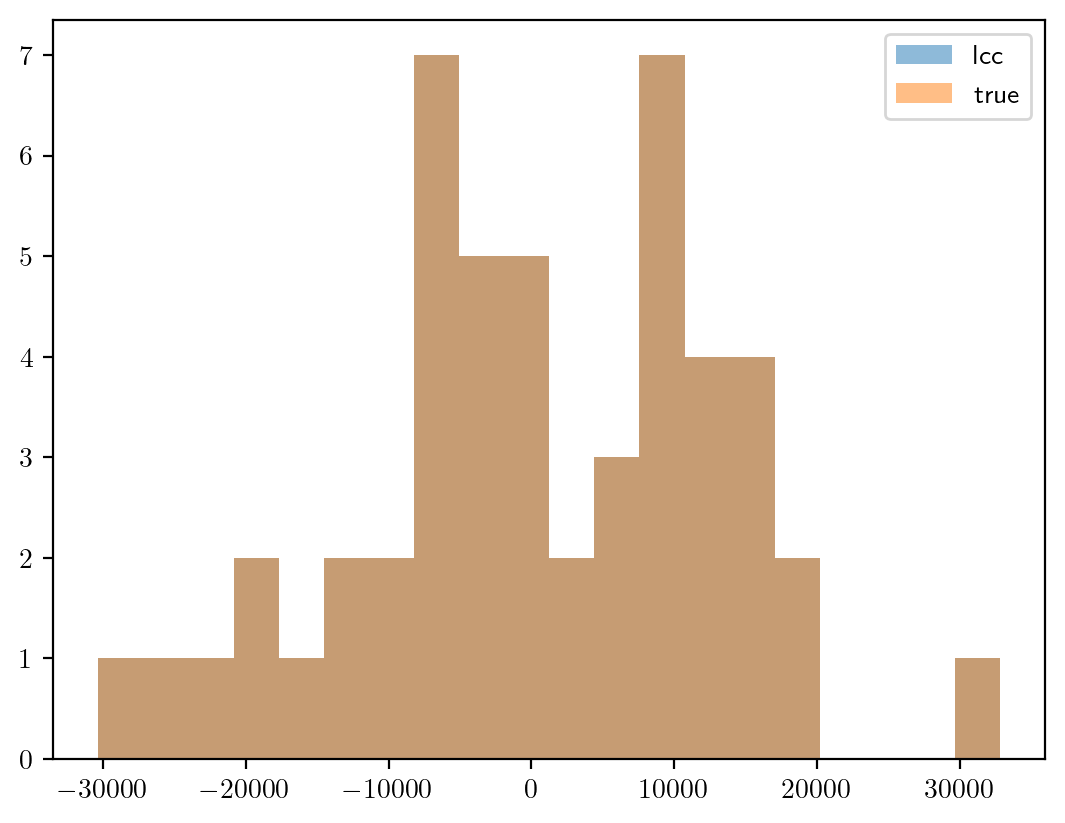

In [277]:
plt.figure()
plt.hist(oracle.grad(random_weight).real, bins=20, alpha=0.5, label="lcc")
plt.hist(oracle._debug_grad(random_weight), bins=20, alpha=0.5, label="true")
plt.legend()
plt.show()

In [29]:
import liboptpy.unconstr_solvers as solvers
import liboptpy.step_size as ss

In [30]:
import matplotlib as mpl
import sys

mpl.rcParams.update(mpl.rcParamsDefault)
sys.path.append("/Library/TeX/texbin/latex")
plt.rc("text", usetex=True)

In [114]:
max_iter = 500
tol = 1e-12
L = np.linalg.norm(oracle.X) ** 2 / 4
step_size = 1 / L
# optim = solvers.fo.AcceleratedGD(oracle._debug_func, oracle._debug_grad, ss.Backtracking(rule_type="Lipschitz", rho=0.5, eps=1e-2, init_alpha=0.5))
optim = solvers.fo.AcceleratedGD(
    oracle._debug_func, oracle._debug_grad, ss.ConstantStepSize(step_size)
)
w0 = np.ones(num_features)
w_opt = optim.solve(w0, max_iter, tol, disp=True)
optim.convergence.append(w_opt)
f_vals = [oracle._debug_func(w) for w in optim.convergence]
grad_vals = [np.linalg.norm(oracle._debug_grad(w)) ** 2 for w in optim.convergence]

Maximum iteration exceeds!
Convergence in 500 iterations
Function value = 2.361351963293628e-21
Norm of gradient = 5.914427899639055e-09


In [278]:
num_workers = 30
num_stragglers = 5
security_guarantee = 0
privacy_guarantee = 3
beta = 1.1
sigmas = [100, 1000, 10000, 100000, 1000000]
fit_intercept = False

coded_grad_vals = {}
for sigma in sigmas:
    oracle = ALCCLeastSquaresOracle(
        X_train,
        y_train,
        num_workers=num_workers,
        num_stragglers=num_stragglers,
        security_guarantee=security_guarantee,
        privacy_guarantee=privacy_guarantee,
        beta=beta,
        sigma=sigma,
        fit_intercept=fit_intercept,
    )
    max_iter = 500
    tol = 1e-12
    optim = solvers.fo.AcceleratedGD(
        oracle.func, oracle.grad, ss.ConstantStepSize(step_size)
    )
    w0 = np.ones(num_features)
    w_opt = optim.solve(w0, max_iter, tol, disp=True)
    optim.convergence.append(w_opt)
    coded_grad_vals[sigma] = [
        np.linalg.norm(oracle._debug_grad(w)) ** 2 for w in optim.convergence
    ]

Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=25
Maximum iteration exceeds!
Convergence in 500 iterations
Function value = 4.0122561133740824e-19
Norm of gradient = 1.0462060723286108e-07
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=25
Maximum iteration exceeds!
Convergence in 500 iterations
Function value = 4.248198167151473e-15
Norm of gradient = 8.5121593294116e-06
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=25


KeyboardInterrupt: 

In [221]:
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

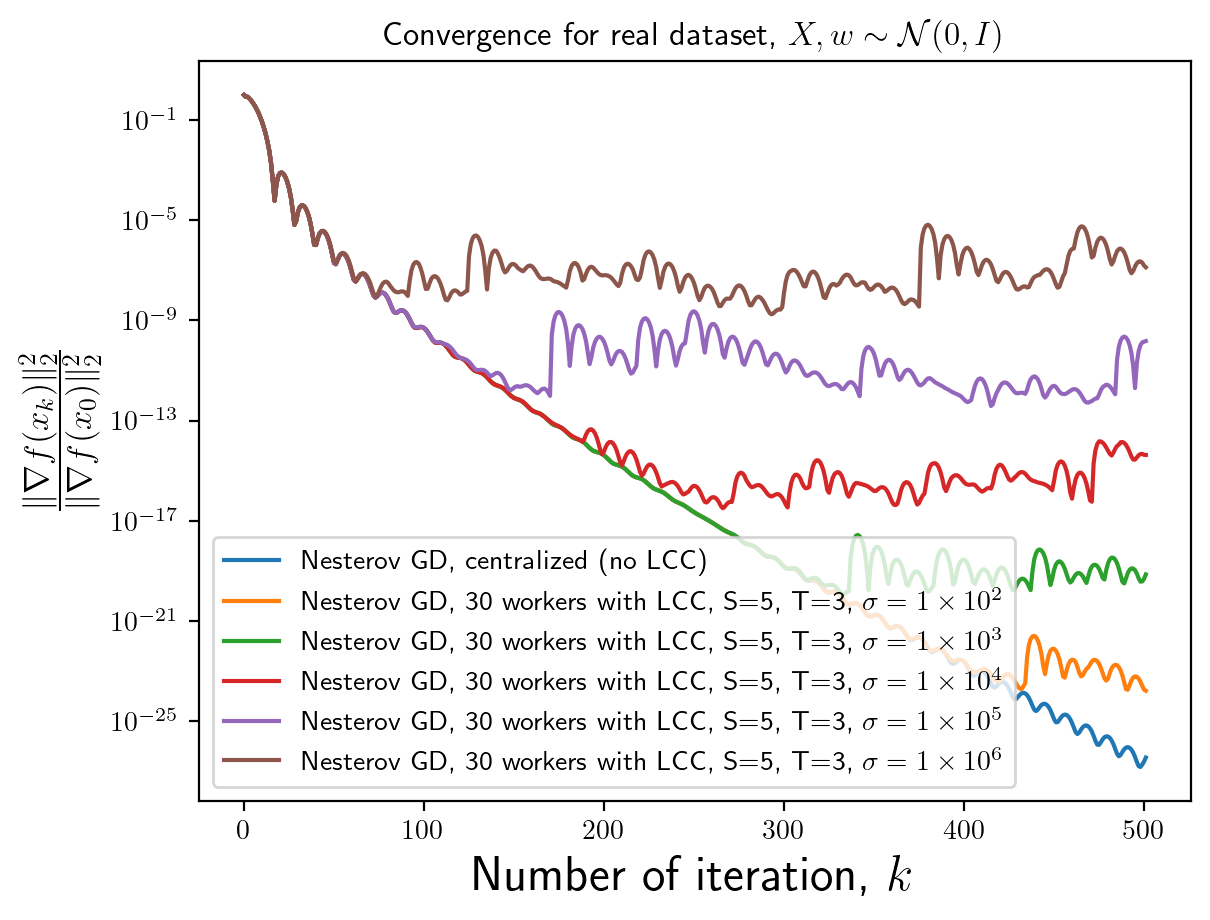

In [222]:
plt.title(r"Convergence for real dataset, $X, w \sim \mathcal{N}(0, I)$")
plt.xlabel(r"Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(
    r"$\frac{\| \nabla f(x_k)\|^2_2}{\| \nabla f(x_0)\|^2_2}$", fontsize=fontsize
)
plt.plot(grad_vals / grad_vals[0], label="Nesterov GD, centralized (no LCC)")

for sigma in sigmas:
    coded_grad = coded_grad_vals[sigma]
    plt.plot(
        coded_grad / coded_grad[0],
        label=r"{}".format(
            f"Nesterov GD, 30 workers with LCC, S={oracle.num_stragglers}, T={oracle.privacy_guarantee}, $\sigma={latex_float(sigma)}$"
        ),
    )
# plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.savefig("lcc_int.pdf")
plt.show()

In [279]:
num_workers = 30
num_stragglers = 5
security_guarantee = 0
privacy_guarantee = 3
betas = [1.01, 1.05, 1.1, 1.25, 1.75]
# sigmas = [10, 100, 1000, 10000]
sigma = "adaptive"
fit_intercept = False

coded_grad_vals = {}
for beta in betas:
    oracle = ALCCLeastSquaresOracle(
        X_train,
        y_train,
        num_workers=num_workers,
        num_stragglers=num_stragglers,
        security_guarantee=security_guarantee,
        privacy_guarantee=privacy_guarantee,
        beta=beta,
        sigma=sigma,
        fit_intercept=fit_intercept,
    )
    max_iter = 500
    tol = 1e-12
    optim = solvers.fo.AcceleratedGD(
        oracle.func, oracle.grad, ss.ConstantStepSize(step_size)
    )
    w0 = np.ones(num_features)
    w_opt = optim.solve(w0, max_iter, tol, disp=True)
    optim.convergence.append(w_opt)
    coded_grad_vals[beta] = [
        np.linalg.norm(oracle._debug_grad(w)) ** 2 for w in optim.convergence
    ]

Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=25
Maximum iteration exceeds!
Convergence in 500 iterations
Function value = 2.3789971500918256e-21
Norm of gradient = 5.961662280846264e-09
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=25
Maximum iteration exceeds!
Convergence in 500 iterations
Function value = 2.3697970134512678e-21
Norm of gradient = 5.942068785683139e-09
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=25
Maximum iteration exceeds!
Convergence in 500 iterations
Function value = 2.3544351051941187e-21
Norm of gradient = 5.906511969562635e-09
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=25
Maximum iteration exceeds!
Convergence in 500 iterations
Function value = 2.77915606582721e-21
Norm of gradient = 6.02441988253401e-09
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=25
Maximum iteration exceeds!
Convergence in 500 

In [290]:
oracle.X.flatten().std(), oracle.Z.sum(0).flatten().std()

(1.0008053086037032, 1.0014006710744674)

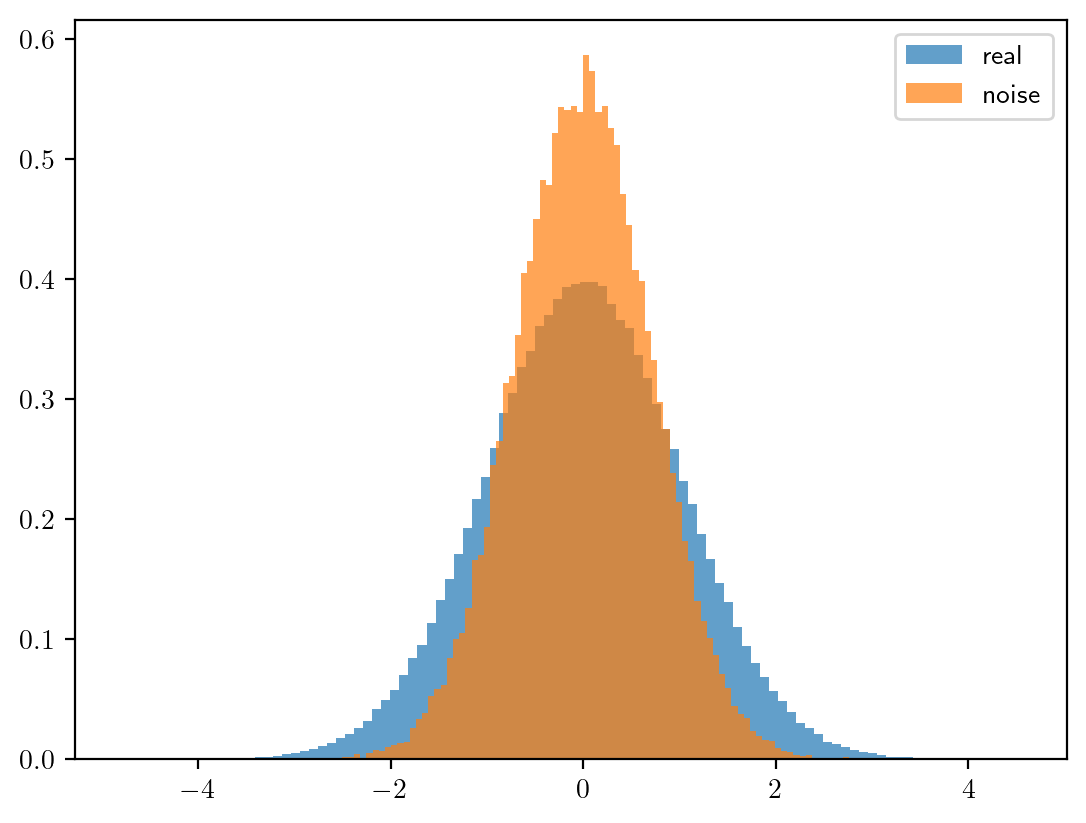

In [289]:
plt.hist(oracle.X.real.flatten(), bins=100, alpha=0.7, label="real", density=True)
plt.hist(
    oracle.Z.real.sum(0).flatten(), bins=100, alpha=0.7, label="noise", density=True
)
plt.legend()
plt.show()

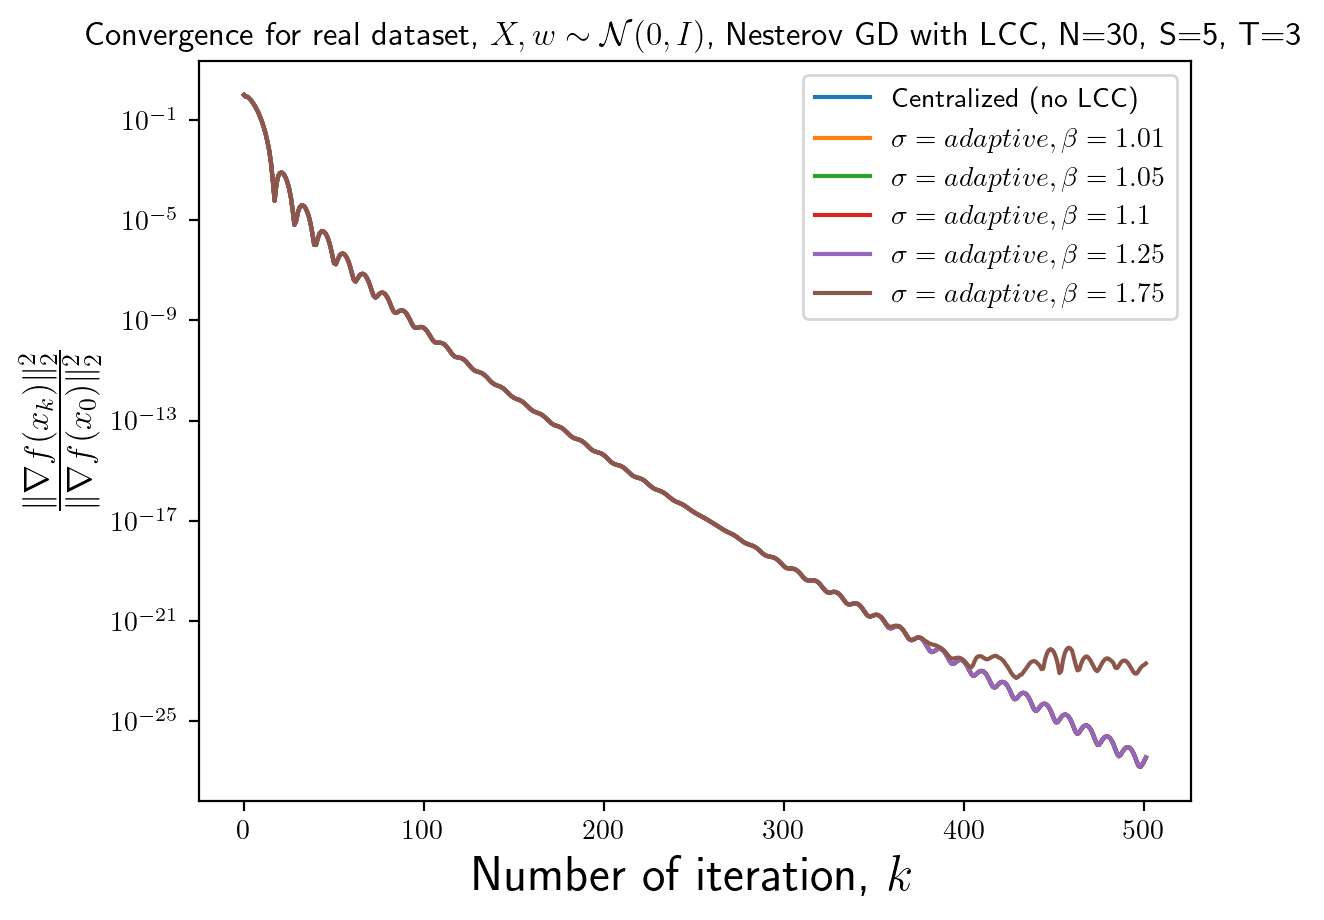

In [291]:
plt.title(
    r"{}".format(
        "Convergence for real dataset, $X, w \sim \mathcal{N}(0, I)$, "
        + f"Nesterov GD with LCC, N={oracle.num_workers}, S={oracle.num_stragglers}, T={oracle.privacy_guarantee}"
    )
)
plt.xlabel(r"Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(
    r"$\frac{\| \nabla f(x_k)\|^2_2}{\| \nabla f(x_0)\|^2_2}$", fontsize=fontsize
)
plt.plot(grad_vals / grad_vals[0], label="Centralized (no LCC)")

for beta in betas:
    coded_grad = coded_grad_vals[beta]
    plt.plot(
        coded_grad / coded_grad[0],
        label=r"{}".format(f"$\sigma={sigma}, \\beta={beta}$"),
    )
# plt.xscale("log")
plt.yscale("log")
plt.legend()
# plt.savefig("lcc_real.pdf")
plt.show()

In [163]:
bits_float = np.array(bits, dtype="float64")

In [ ]:
num_workers = 30
num_stragglers = 5
security_guarantee = 0
privacy_guarantee = 3
betas = 1 + np.logspace(-3, 0, 4)
sigmas = [10, 100, 1000, 10000]
fit_intercept = False

coded_grad_vals = {}
for sigma in sigmas:
    oracle = ALCCLeastSquaresOracle(
        X_train,
        y_train,
        num_workers=num_workers,
        num_stragglers=num_stragglers,
        security_guarantee=security_guarantee,
        privacy_guarantee=privacy_guarantee,
        beta=beta,
        sigma=sigma,
        fit_intercept=fit_intercept,
    )
    max_iter = 500
    tol = 1e-12
    optim = solvers.fo.AcceleratedGD(
        oracle.func, oracle.grad, ss.ConstantStepSize(step_size)
    )
    w0 = np.ones(num_features)
    w_opt = optim.solve(w0, max_iter, tol, disp=True)
    optim.convergence.append(w_opt)
    coded_grad_vals[sigma] = [
        np.linalg.norm(oracle._debug_grad(w)) ** 2 for w in optim.convergence
    ]

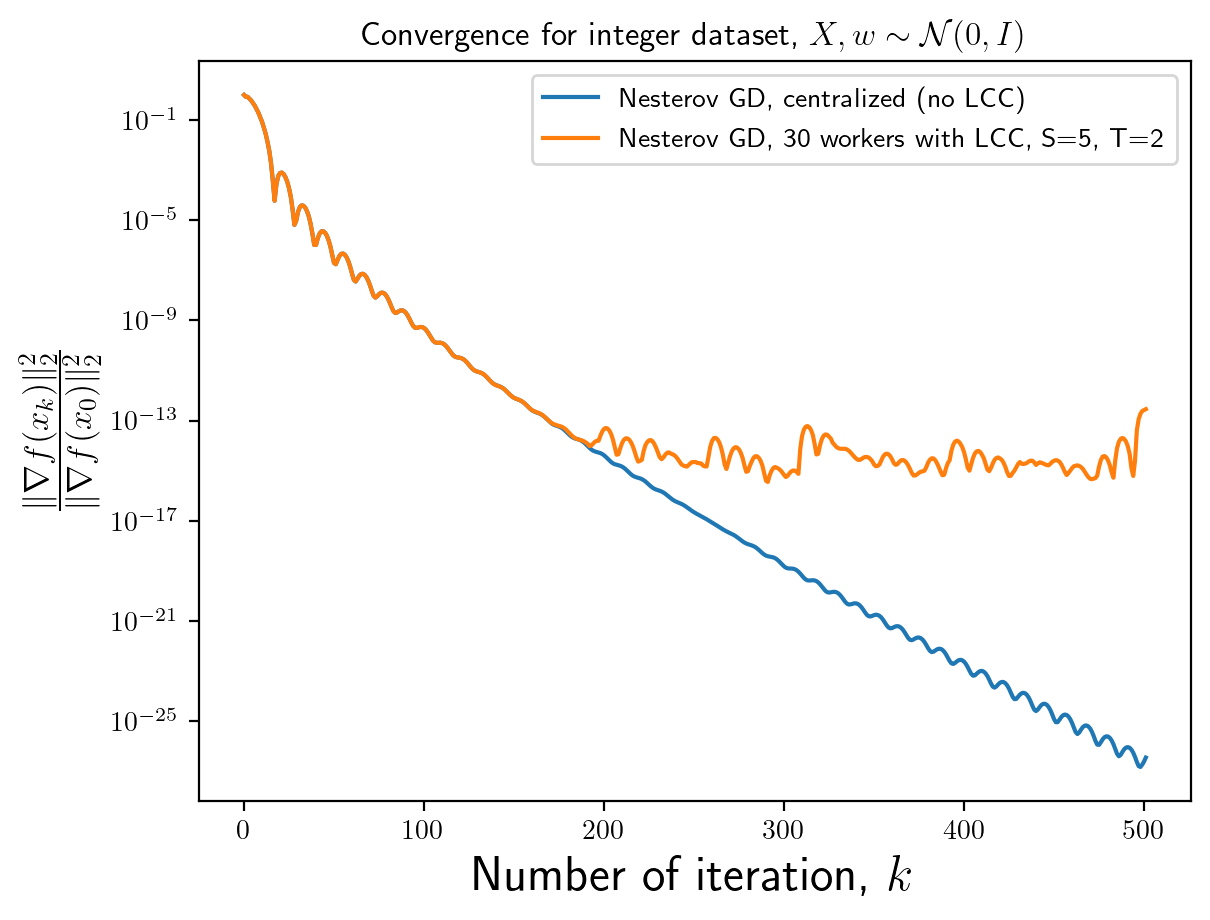

In [139]:
plt.title(r"Convergence for integer dataset, $X, w \sim \mathcal{N}(0, I)$")
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(
    r"$\frac{\| \nabla f(x_k)\|^2_2}{\| \nabla f(x_0)\|^2_2}$", fontsize=fontsize
)
plt.plot(grad_vals / grad_vals[0], label="Nesterov GD, centralized (no LCC)")
plt.plot(
    coded_grad_vals / coded_grad_vals[0],
    label=f"Nesterov GD, 30 workers with ALCC, S={oracle.num_stragglers}, T={oracle.privacy_guarantee}, sigma={}",
)
# plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.savefig("lcc_int.pdf")
plt.show()

In [ ]:
class LCCMatMul():
    """
    LCC matrix multiplication A.T.dot(B)
    """
    def __init__(self, A, B, prime_number,
                num_workers=40,
                num_stragglers=5,
                security_guarantee=2,
                privacy_guarantee=2,
                precision=16):
        self.A = A
        self.B = B
        self.Aq = lcc.quantize(A, precision, prime_number)
        self.Bq = lcc.quantize(B, precision, prime_number)

        self.num_workers = num_workers # N
        self.num_stragglers = num_stragglers # S
        self.security_guarantee = security_guarantee # A
        self.privacy_guarantee = privacy_guarantee # T
        self.prime_number = prime_number
        self.precision = precision

        self._init_num_batches() # K
        self._precomputation()

    def _init_num_batches(self):
        self.poly_degree = 4 # X.T.dot(X)
        self.num_batches = (self.num_workers - 1 - 2 * self.security_guarantee \
                           - self.num_stragglers) // self.poly_degree + 1 - self.privacy_guarantee
        m, _ = self.X.shape
        while m % self.num_batches:
            self.num_batches -= 1
        self.n_bound = (self.num_batches + self.privacy_guarantee - 1) * self.poly_degree \
                       - self.num_stragglers + 2 * self.security_guarantee + 1 
        print(f"Initialized K={self.num_batches} batches")
        print(f"Numbers of workers to restore correctly: N>={self.n_bound}")

    def _precomputation(self):
        n_betas = self.num_batches + self.privacy_guarantee
        n_alphas = self.num_workers
        self.alphas = (np.arange(n_alphas) + 1).astype("int64")
        self.betas = (np.arange(n_betas) + 1 + n_alphas).astype("int64")
        self.U = lcc.gen_Lagrange_coeffs(self.alphas, self.betas, self.prime_number)
        Xq_split = np.stack(np.split(self.Xq, self.num_batches))
        self.Z = np.random.randint(0, self.prime_number, 
                                   (self.privacy_guarantee, *Xq_split.shape[1:])).astype("int64")
        X_to_encode = np.concatenate([Xq_split, self.Z])
        self.X_encoded = np.mod(np.einsum("kn,kmd->nmd", self.U, X_to_encode), self.prime_number) # N x (m // K) x d

    def _worker_func(self, X, w):
        wq = lcc.quantize(w, self.precision, self.prime_number)
        return np.mod(X.dot(wq), self.prime_number) # (N - S) x (m // K)

    def func(self, w):
        succeeded_workers = np.random.choice(self.num_workers, 
                                             self.num_workers - self.num_stragglers, 
                                             replace=False)
        func_encoded = self._worker_func(self.X_encoded[succeeded_workers], w)
        if self.security_guarantee > 0:
            raise NotImplementedError("Adversarial decoding not yet supported!")
        else:
            U_dec = lcc.gen_Lagrange_coeffs(self.betas[:self.num_batches], 
                                            self.alphas[succeeded_workers], 
                                            self.prime_number)
            func_decoded = np.mod(np.einsum("nk,nm->km", U_dec, func_encoded), self.prime_number)
            self.worker_func = lcc.dequantize(func_decoded, self.precision, self.prime_number)
        return 0.5 * ((self.worker_func.reshape(-1) - self.y) ** 2).mean()

    def _debug_func(self, w):
        return 0.5 * ((self.X.dot(w) - self.y) ** 2).mean()

In [127]:
def compare_costs(degrees, n_computations, T=1, A=1):
    total_computations = n_computations.sum()
    costs = {}
    costs["Scheme 0"] = (
        total_computations,
        degrees.max() * (total_computations + T - 1) + 2 * A + 1,
    )
    costs["Schemes I-II"] = (
        total_computations,
        (degrees * (n_computations + T - 1) + 2 * A + 1).sum(),
    )
    costs["Scheme III"] = (
        total_computations,
        (degrees * (n_computations + T - 1) + total_computations - n_computations).max()
        + 2 * A
        + 1,
    )
    return costs

In [153]:
n_polynomials = 50
degrees = 2 ** (1 + np.arange(n_polynomials))
n_computations = 1 + np.arange(n_polynomials)
compare_costs(degrees, n_computations)

{'Scheme 0': (1275, 1435522381224345603),
 'Schemes I-II': (1275, 110338190870577304),
 'Scheme III': (1275, 56294995342132428)}

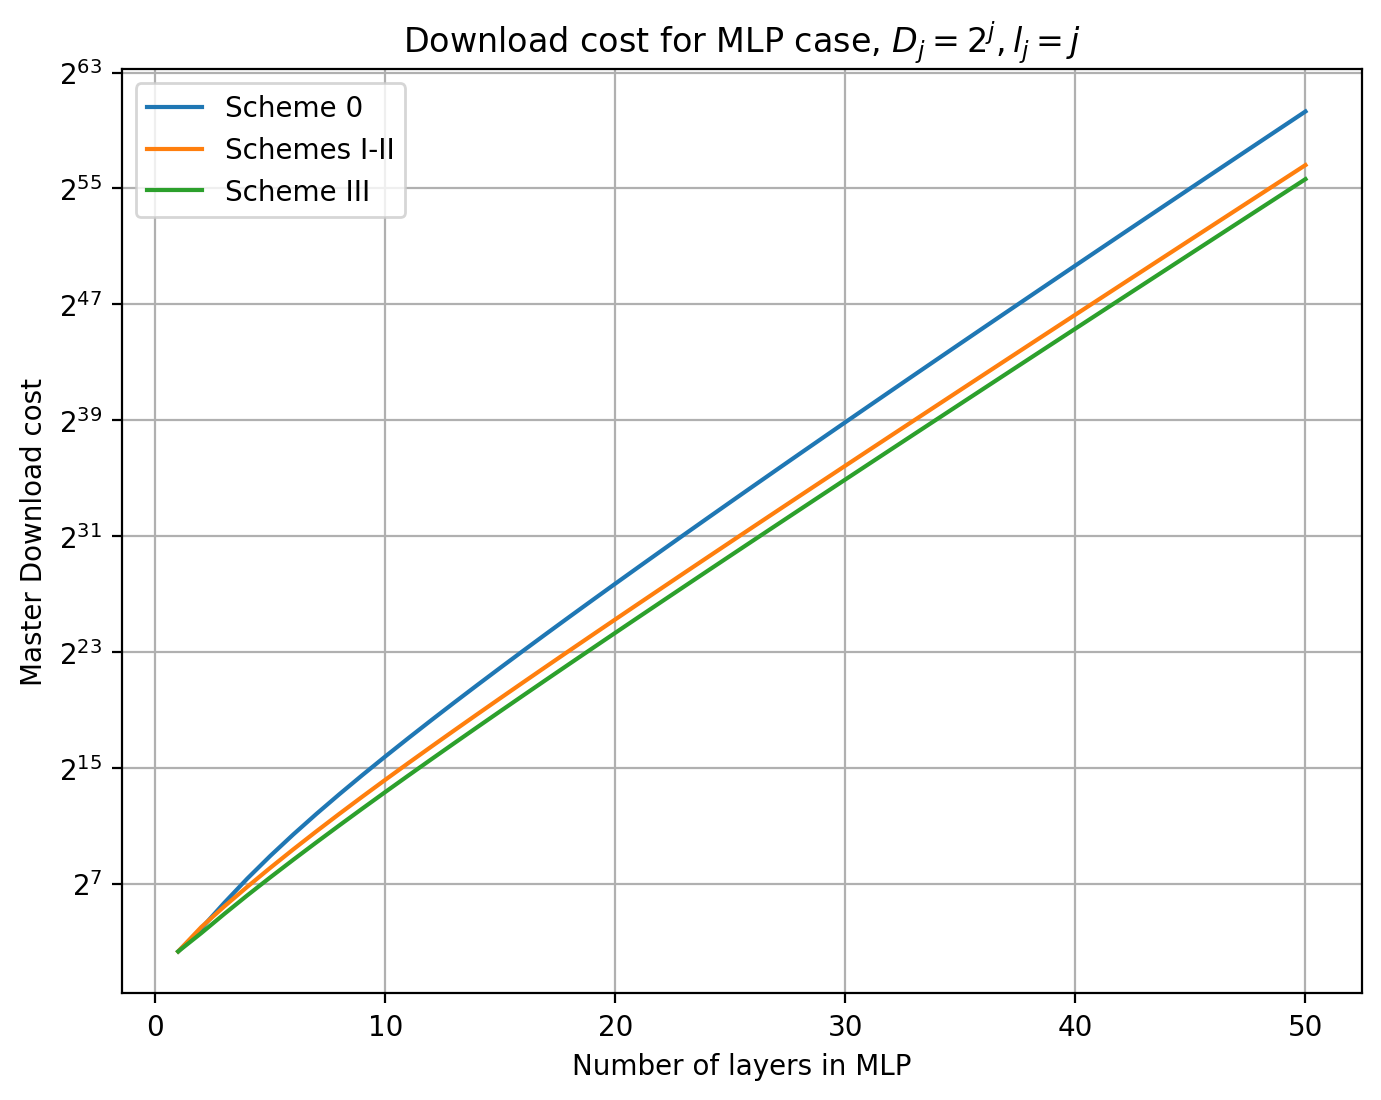

In [164]:
L_range = 1 + np.arange(50)
all_costs = {k: [] for k in ["Scheme 0", "Schemes I-II", "Scheme III"]}
for n_polynomials in L_range:
    degrees = 2 ** (1 + np.arange(n_polynomials))
    n_computations = 1 + np.arange(n_polynomials)
    new_costs = compare_costs(degrees, n_computations)
    [all_costs[scheme].append(new_costs[scheme]) for scheme in new_costs.keys()]
for scheme, costs in all_costs.items():
    costs = np.array(costs)
    plt.plot(L_range, costs[:, 1], label=scheme)
plt.xlabel("Number of layers in MLP")
plt.ylabel("Master Download cost")
plt.title("Download cost for MLP case, $D_j=2^j, l_j=j$")
plt.grid()
# plt.xscale("log")
plt.yscale("log", base=2)
plt.legend()

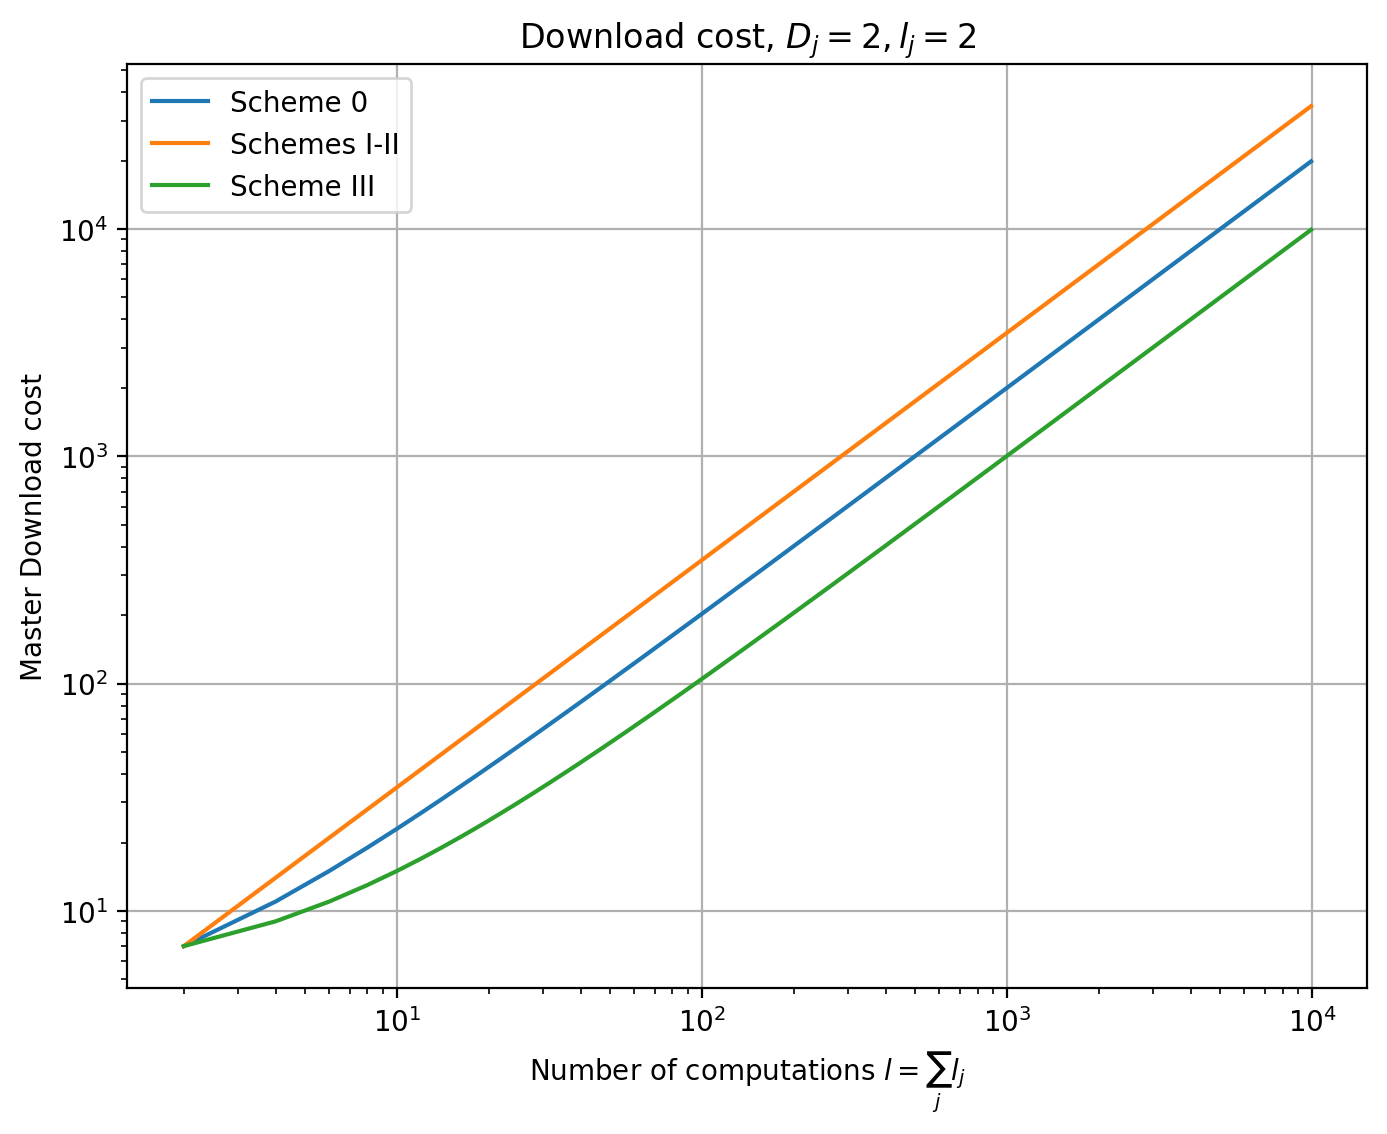

In [129]:
L_range = np.unique(np.logspace(0, 4, 1000).astype(int))
all_costs = {k: [] for k in ["Scheme 0", "Schemes I-II", "Scheme III"]}
for n_polynomials in L_range:
    degrees = 2 * np.ones(n_polynomials)
    n_computations = 2 * np.ones(n_polynomials)
    if n_computations.sum() > 1e4:
        break
    new_costs = compare_costs(degrees, n_computations)
    [all_costs[scheme].append(new_costs[scheme]) for scheme in new_costs.keys()]
for scheme, costs in all_costs.items():
    costs = np.array(costs)
    plt.plot(costs[:, 0], costs[:, 1], label=scheme)
plt.xlabel("Number of computations $l=\sum_j l_j$")
plt.ylabel("Master Download cost")
plt.title("Download cost, $D_j=2, l_j=2$")
plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.legend()

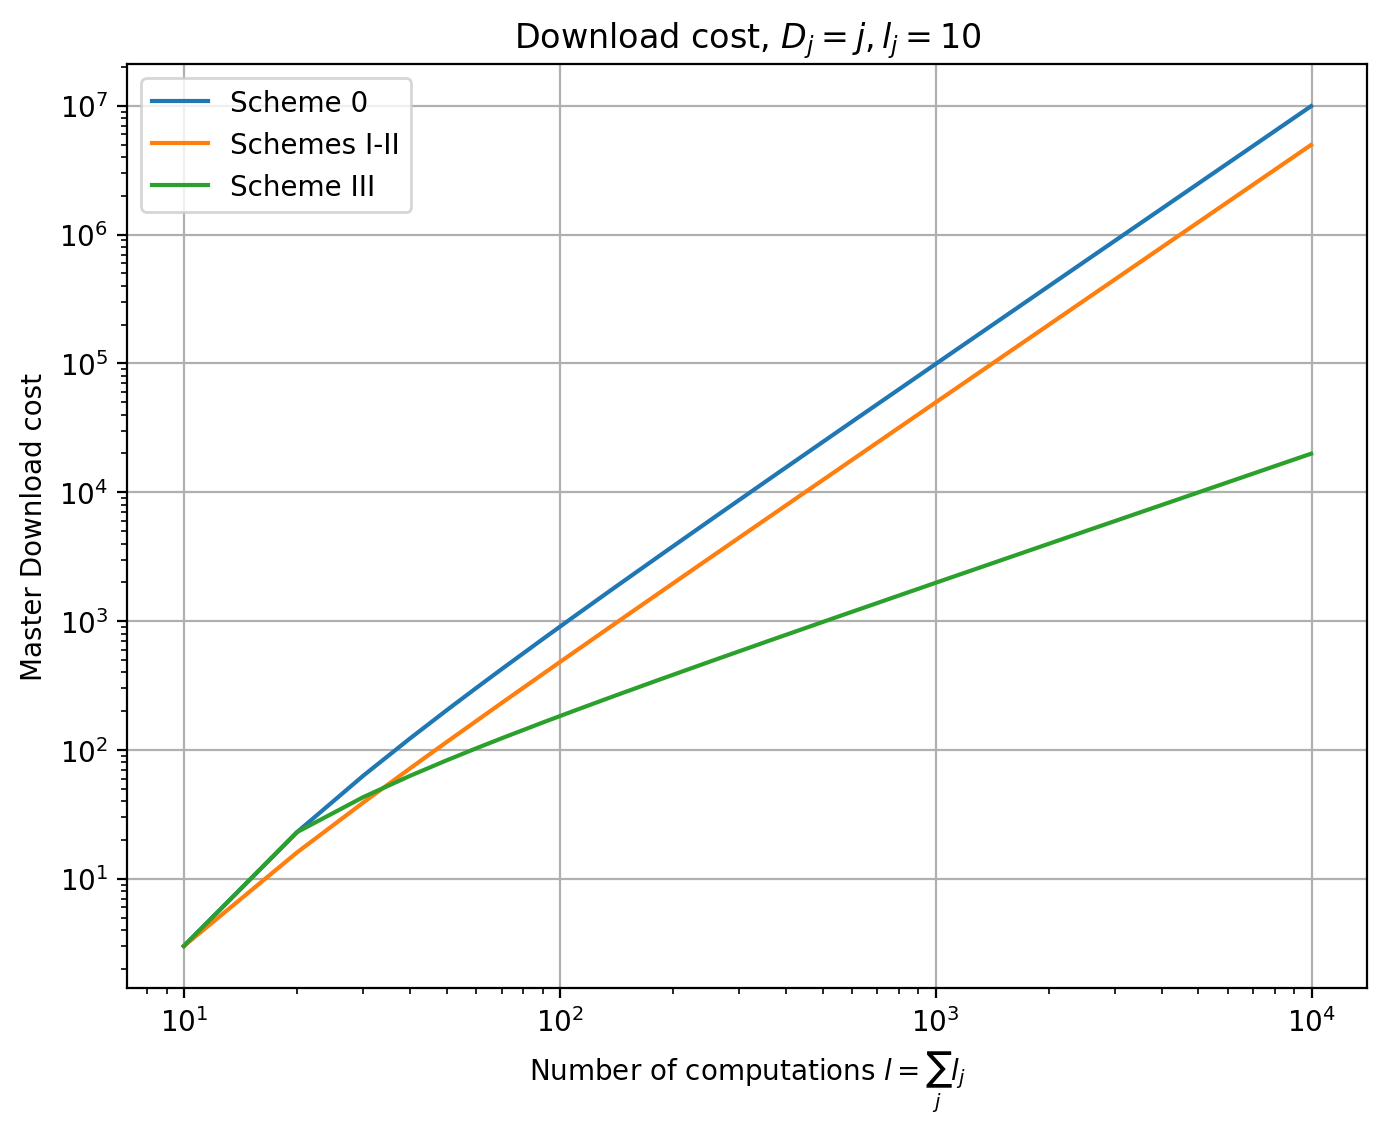

In [130]:
L_range = np.unique(np.logspace(0, 4, 1000).astype(int))
all_costs = {k: [] for k in ["Scheme 0", "Schemes I-II", "Scheme III"]}
for n_polynomials in L_range:
    degrees = np.arange(n_polynomials)
    n_computations = 10 * np.ones(n_polynomials)
    if n_computations.sum() > 1e4:
        break
    new_costs = compare_costs(degrees, n_computations)
    [all_costs[scheme].append(new_costs[scheme]) for scheme in new_costs.keys()]
for scheme, costs in all_costs.items():
    costs = np.array(costs)
    plt.plot(costs[:, 0], costs[:, 1], label=scheme)
plt.xlabel("Number of computations $l=\sum_j l_j$")
plt.ylabel("Master Download cost")
plt.title("Download cost, $D_j=j, l_j=10$")
plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.legend()

In [132]:
all_costs

{'Scheme 0': [(1000.0, 10003.0),
  (2000.0, 20003.0),
  (3000.0, 30003.0),
  (4000.0, 40003.0),
  (5000.0, 50003.0),
  (6000.0, 60003.0),
  (7000.0, 70003.0),
  (8000.0, 80003.0),
  (9000.0, 90003.0),
  (10000.0, 100003.0)],
 'Schemes I-II': [(1000.0, 10003.0),
  (2000.0, 20006.0),
  (3000.0, 30009.0),
  (4000.0, 40012.0),
  (5000.0, 50015.0),
  (6000.0, 60018.0),
  (7000.0, 70021.0),
  (8000.0, 80024.0),
  (9000.0, 90027.0),
  (10000.0, 100030.0)],
 'Scheme III': [(1000.0, 10003.0),
  (2000.0, 11003.0),
  (3000.0, 12003.0),
  (4000.0, 13003.0),
  (5000.0, 14003.0),
  (6000.0, 15003.0),
  (7000.0, 16003.0),
  (8000.0, 17003.0),
  (9000.0, 18003.0),
  (10000.0, 19003.0)]}

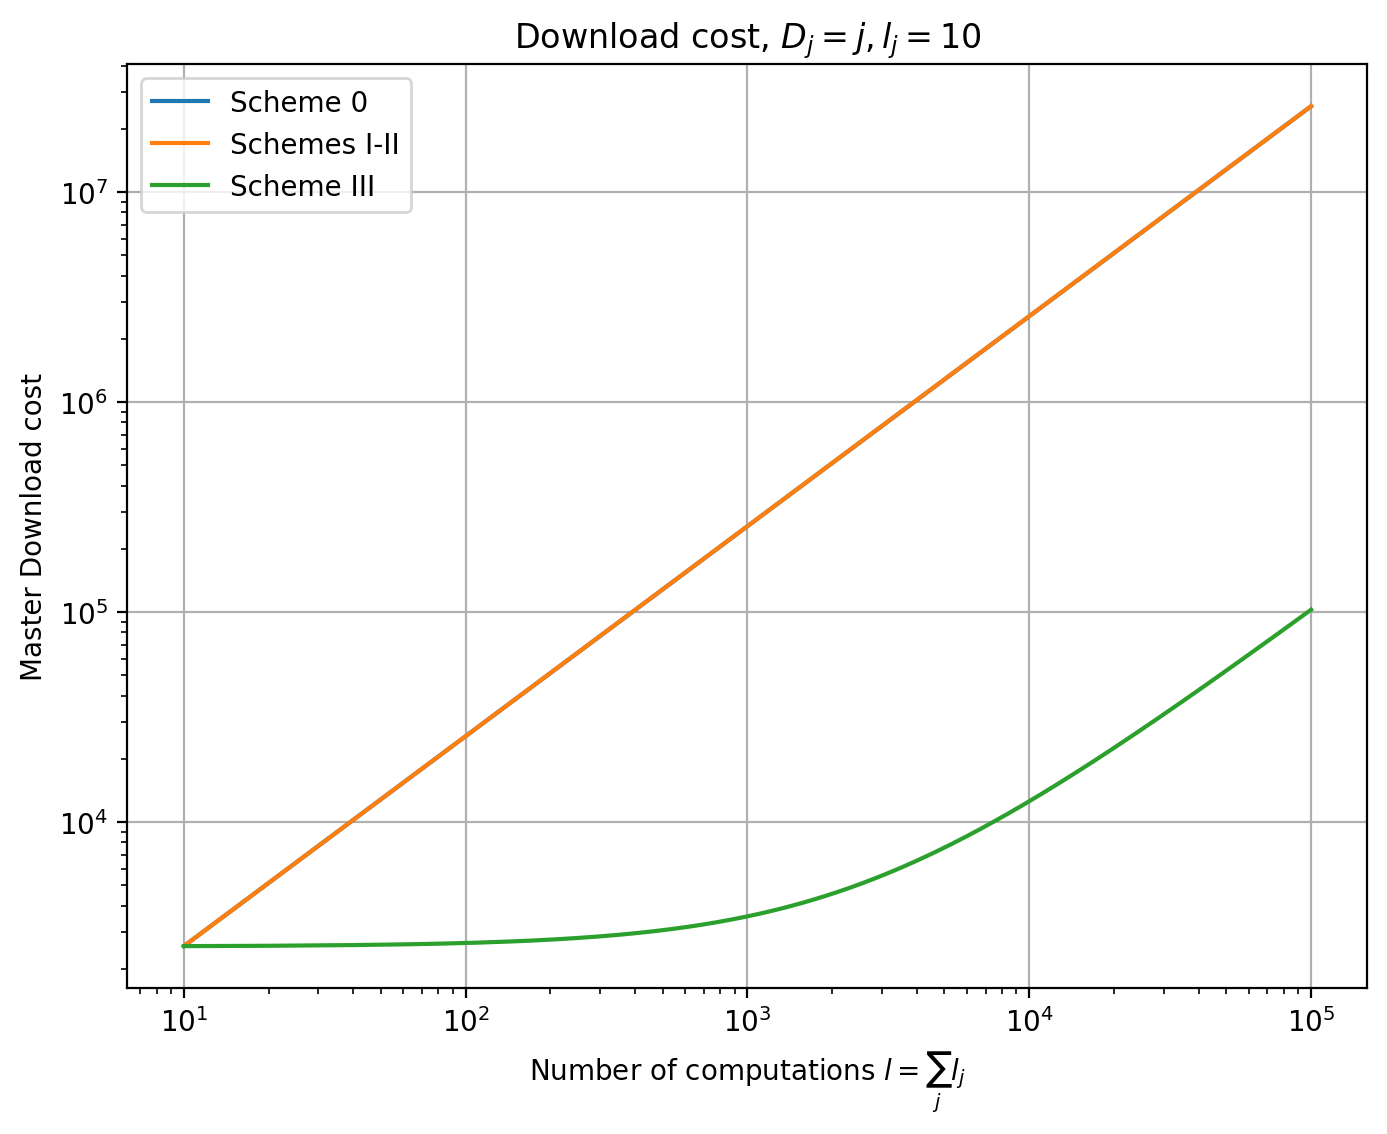

In [146]:
L_range = np.unique(np.logspace(0, 4, 1000).astype(int))
all_costs = {k: [] for k in ["Scheme 0", "Schemes I-II", "Scheme III"]}
for n_polynomials in L_range:
    degrees = 256 * np.ones(n_polynomials)
    n_computations = 10 * np.ones(n_polynomials)
    new_costs = compare_costs(degrees, n_computations)
    [all_costs[scheme].append(new_costs[scheme]) for scheme in new_costs.keys()]
for scheme, costs in all_costs.items():
    costs = np.array(costs)
    plt.plot(costs[:, 0], costs[:, 1], label=scheme)
plt.xlabel("Number of computations $l=\sum_j l_j$")
plt.ylabel("Master Download cost")
plt.title("Download cost, $D_j=j, l_j=10$")
plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.legend()

In [135]:
all_costs

{'Scheme 0': [(1000.0, 10003.0),
  (2000.0, 20003.0),
  (3000.0, 30003.0),
  (4000.0, 40003.0),
  (5000.0, 50003.0),
  (6000.0, 60003.0),
  (7000.0, 70003.0),
  (8000.0, 80003.0),
  (9000.0, 90003.0),
  (10000.0, 100003.0),
  (11000.0, 110003.0),
  (12000.0, 120003.0),
  (13000.0, 130003.0),
  (14000.0, 140003.0),
  (15000.0, 150003.0),
  (16000.0, 160003.0),
  (17000.0, 170003.0),
  (18000.0, 180003.0),
  (19000.0, 190003.0),
  (20000.0, 200003.0),
  (21000.0, 210003.0),
  (22000.0, 220003.0),
  (23000.0, 230003.0),
  (24000.0, 240003.0),
  (25000.0, 250003.0),
  (26000.0, 260003.0),
  (27000.0, 270003.0),
  (28000.0, 280003.0),
  (29000.0, 290003.0),
  (30000.0, 300003.0),
  (31000.0, 310003.0),
  (32000.0, 320003.0),
  (33000.0, 330003.0),
  (34000.0, 340003.0),
  (35000.0, 350003.0),
  (36000.0, 360003.0),
  (37000.0, 370003.0),
  (38000.0, 380003.0),
  (39000.0, 390003.0),
  (40000.0, 400003.0),
  (41000.0, 410003.0),
  (42000.0, 420003.0),
  (43000.0, 430003.0),
  (44000.0, 44000